# NDVI Phenology
<hr>
# Notebook Summary

* LANDSAT 7 and LANDSAT 8 are used to detect changes in plant life over time.
* Very basic xarray manipulations are performed.
* The data is cleaned of clouds and scanlines.

<hr>
# Algorithmic process  

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Understand filtering of cloud data and scan lines](#filter)
* [Retrieve the data from the datacube](#retrieve_data)
* [Obtain the clean mask](#obtain_clean_mask)
* [Filter out clouds, scan lines, and invalid data](#clean_mask)
* [Calculate NDVI](#calculate)
* [Examine the selected area](#area_analysis)
* [Examine the selected point](#point_analysis)

<hr>
# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from dc_notebook_utilities import generate_metadata_report
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime as dt
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
import utils.data_cube_utilities.plotter_utils as plotter

# Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose Platform and Product</a>

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
8,LANDSAT_7,ls7_collections_sr_scene
67,LANDSAT_7,ls7_collections_sr_scene_lean
78,LANDSAT_7,ls7_collections_sr_scene_mini
19,LANDSAT_7,ls7_ledaps_amazon_river
20,LANDSAT_7,ls7_ledaps_bangladesh
35,LANDSAT_7,ls7_ledaps_bangladesh_bari
87,LANDSAT_7,ls7_ledaps_caqueta
21,LANDSAT_7,ls7_ledaps_colombia
22,LANDSAT_7,ls7_ledaps_ghana


In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
9,LANDSAT_8,ls8_collections_sr_scene
69,LANDSAT_8,ls8_collections_sr_scene_lean
86,LANDSAT_8,ls8_lasrc_caqueta
73,LANDSAT_8,ls8_lasrc_honduras
32,LANDSAT_8,ls8_lasrc_lake_chad_full
33,LANDSAT_8,ls8_lasrc_meta_river
70,LANDSAT_8,ls8_lasrc_samoa
83,LANDSAT_8,ls8_lasrc_swiss_mini
77,LANDSAT_8,ls8_lasrc_switzerland


In [4]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration. Only select one LANDSAT 7 product, 
# one LANDSAT 8 product, or one of both. The products must have similar areas.
platforms = ["LANDSAT_7", "LANDSAT_8"] # Must be list            
products = ["ls7_ledaps_vietnam", "ls8_lasrc_vietnam"] # Must be list   

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Get the Extents of the Cube</a>

In [6]:
min_max_dates = np.empty((len(platforms), 2), dtype=object)
min_max_lat = np.empty((len(platforms), 2))
min_max_lon = np.empty((len(platforms), 2))
for i, (platform, product) in enumerate(zip(platforms, products)):
    # Get the extents of the cube
    descriptor = api.get_query_metadata(platform=platform, product=product)

    # Save extents
    min_max_dates[i] = descriptor['time_extents']#(min_date, max_date)
    min_max_lat[i] = descriptor['lat_extents']#(min_lat, max_lat)
    min_max_lon[i] = descriptor['lon_extents']#(min_lon, max_lon)
    
# Determine minimum and maximum longitudes that bound a common area among products
min_lon = np.max(min_max_lon[:,0]) # The greatest minimum longitude among products
max_lon = np.min(min_max_lon[:,1]) # The smallest maximum longitude among products
min_lat = np.max(min_max_lat[:,0])
max_lat = np.min(min_max_lat[:,1])
full_lon = (min_lon, max_lon)
full_lat = (min_lat, max_lat)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <a id="define_extents">Define the Extents of the Analysis</a>

**Specify start and end dates in the same order as platforms and products**

In [7]:
# Use these four lines to select the time slice common to all products.
# min_start_date_mutual = np.max(min_max_dates[:,0])
# max_end_date_mutual = np.min(min_max_dates[:,1])
# start_dates = [min_start_date_mutual, min_start_date_mutual]
# end_dates = [max_end_date_mutual, max_end_date_mutual]
# Use these two lines to select all data available to each product.
start_dates = min_max_dates[:,0]
end_dates = min_max_dates[:,1]

**Specify an area and a point within it to analyze**

In [8]:
# Specify latitude and longitude bounds of an interesting area within the full extents
# shown in the metadata report above (reduce area for faster processing times).
min_lon_small, max_lon_small = (107.15, 107.20)
# min_lon_small_area, max_lon_small_area = (106.8, 106.92)
min_lat_small, max_lat_small = (10.95, 11.00)
# min_lat_small_area, max_lat_small_area = (11.10, 11.39)
# Choose an interesting point within the specified area (a pixel, not an area).
lon_point = 107.2086
# lon_point = 106.8540
lat_point = 10.9790
# lat_point = 11.1445

**Visualize the selected area**

In [9]:
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

**Visualize the selected point**

In [10]:
# Display the subset of the region to be analyzed.
display_map((lat_point, lat_point), (lon_point, lon_point))

## <a id="retrieve_data">Retrieve the data from the datacube</a>

In [11]:
from datetime import datetime as dt
measurements = ['red', 'nir', 'pixel_qa']
datasets_in = {}
for i, (product,platform) in enumerate(zip(products, platforms)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    # Query the Data Cube
    dataset_in = dc.load(lat = lat_small,
                         lon = lon_small,
                         platform = platform,
                         time = (start_date, end_date),
                         product = product,
                         measurements = measurements)
    if len(dataset_in.dims) > 0: # Sometimes data is not returned.
        datasets_in[platform] = dataset_in

## <a id="obtain_clean_mask">Obtain the clean masks</a>

**For more information on masking, please refer to Masking_Notebook.**

In [12]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Get the clean mask for the LANDSAT satellite platform
clean_masks = {}
for platform in datasets_in.keys():
    clean_masks[platform] = landsat_qa_clean_mask(datasets_in[platform], platform)

## <a id="clean_mask">Filter out clouds, scan lines, and invalid data</a>

In [13]:
cleaned_datasets = {}
time_ind = 16 # Select a time to show.
for platform in datasets_in.keys():
    dataset_in = datasets_in[platform]
    clean_mask = clean_masks[platform]
    # Remove clouds.
    cleaned_datasets[platform] = dataset_in.where(clean_mask)
    # Remove data that is ouside the accepted range of LANDSAT 7 and 8.
    cleaned_datasets[platform] = landsat_clean_mask_invalid(cleaned_datasets[platform])

## <a id='calculate'>Calculate NDVI</a>

In [14]:
data_arrs = {}
# Dictionary mapping platforms to corresponding DataArrays of computed values.
comp_vals_arrs_dict = {}
for platform in cleaned_datasets.keys():
    data_arrs[platform] = NDVI(cleaned_datasets[platform])
    comp_vals_arrs_dict[platform] = data_arrs[platform].to_dataset(name='comp_vals')
del data_arrs

## <a id="area_analysis">Examine the selected area</a>

**If no plots appear in the figures below, there is no data available for the region selected**

**Date utility functions (cell must be run, but can be ignored)**

In [15]:
def remove_non_unique_ordered_list_str(ordered_list):
    """
    Sets all occurrences of a value in an ordered list after its first occurence to ''.
    For example, ['a', 'a', 'b', 'b', 'c'] would become ['a', '', 'b', '', 'c'].
    """
    prev_unique_str = ""
    for i in range(len(ordered_list)):
        current_str = ordered_list[i]
        if current_str != prev_unique_str:
            prev_unique_str = current_str
        else:
            ordered_list[i] = ""
    return ordered_list

## Date Methods ##

# For February, assume leap years are included.
days_per_month = {1:31, 2:29, 3:31, 4:30, 5:31, 6:30, 
                  7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
# Including January, give 5 weeks to every third month and December.
weeks_per_month = {month_int:num_weeks for (month_int,num_weeks) in zip(days_per_month.keys(), [5,4,4]*3+[5,4,5])}
                  #{month:days/7.0 for month,days in days_per_month.items()}
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def month_int_to_name(month_int):
    """
    Converts an ordinal number for a month (in range [1,12]) to its 3-letter name.
    """
    return month_names[month_int-1]

def week_int_to_month_name(week_int):
    """
    Converts an ordinal number for a week (in range [1,53]) to its 3-letter name.
    """
    month_int = -1
    for current_month_int, current_month_weeks in weeks_per_month.items():
        week_int -= current_month_weeks
        if week_int <= 0:
            month_int = current_month_int
            break
    return month_names[month_int-1]

def day_int_to_month_name(day_int):
    """
    Converts an ordinal number for a day (in range [1,366]) to its 3-letter name.
    """
    month_int = -1
    for current_month_int, current_month_days in days_per_month.items():
        day_int -= current_month_days
        if day_int <= 0:
            month_int = current_month_int
            break
    return month_names[month_int-1]

def naive_months_ticks_by_week(weeks=None):
    """
    Given a list of week numbers (in range [1,53]), returns a list of month strings separated by spaces.
    Covers 53 weeks if no list-like of week numbers is given.
    This is only intended to be used for labeling axes in plotting.
    """
    month_ticks_by_week = []
    if weeks is None: # Give month ticks for all weeks.
        for i in range(len(month_names)):
            num_weeks = weeks_per_month[i+1]
            month_ticks_by_week += [month_names[i]] + ['']*(num_weeks-1)
    else:
        month_ticks_by_week = remove_non_unique_ordered_list_str(list(map(week_int_to_month_name, weeks)))
    return month_ticks_by_week

def naive_months_ticks_by_day(days=None):
    """
    Given a list of day numbers (in range [1,366]), returns a list of month strings separated by spaces.
    Covers 366 days if no list-like of day numbers is given.
    This is only intended to be used for labeling axes in plotting.
    """
    month_ticks_by_day = []
    if days is None: # Give month ticks for all days.
        for i in range(len(month_names)):
            num_days = days_per_month[i+1]
            month_ticks_by_day += [month_names[i]] + ['']*(num_days-1)
    else:
        month_ticks_by_day = remove_non_unique_ordered_list_str(list(map(day_int_to_month_name, days)))
    return month_ticks_by_day

**Area analysis boxplot function (cell must be run, but can be ignored)**

In [16]:
import datetime
import seaborn as sns
def plot_area_boxplot_analysis(resolution='weekly', showfliers=False, fliersize=1.):
    """
    Plot a boxplot analysis for the selected area.
    
    Parameters
    ----------
    resolution: str
        Specifies the time resolution at which to aggregate across years. Can be either 'daily' or 'weekly'.
    showfliers: bool
        Whether or not to show fliers - data points that fall outside the whiskers, by the 1.5 IQR rule.
    fliersize: float
        The size of the fliers.
    """
    def convert_int_to_datetime(time_ints):
        """
        Converts a NumPy array of day or week integers to a list of strings for labelling axes in plotting.
        """
        if resolution=='daily':
            return naive_months_ticks_by_day(time_ints)
        elif resolution=='weekly':
            return naive_months_ticks_by_week(time_ints)
    
    assert resolution in ['daily', 'weekly'], "resolution must be either 'daily' or 'weekly'"
    if resolution=='daily':
        time_str = 'dayofyear'
        all_time_nums = np.arange(1,367)
        xlabel= 'Day of Year'
    elif resolution=='weekly':
        time_str = 'weekofyear'
        all_time_nums = np.arange(1,54)
        xlabel= 'Week of Year'
    
    dfs = [] # A list of dataframes - one for each platform.
    acquisition_time_nums = np.array([]) # All acquisition times (day or week numbers) across all selected platforms.
    for i, platform in enumerate(comp_vals_arrs_dict.keys()):
        data_arr = comp_vals_arrs_dict[platform].comp_vals
        # Mean of computed values across time.
        data = data_arr.groupby('time.'+time_str).mean(dim='time')
        acquisition_time_nums = np.append(acquisition_time_nums, data[time_str].values)
        
        # Cast to a pandas DataFrame (this takes a few minutes for each platform).
        data = data.to_dataframe()
        data['platform'] = platform # This column will be used to color the boxplot.
        dfs.append(data)
    # Combine the product-specific dataframes.
    df = pd.concat(dfs)
    
    # Use the date as a column rather than an index for the seaborn plot.
    df.reset_index(level=time_str, inplace=True)
    
    plt.figure(figsize=(18,9), dpi=300)
    if resolution=='daily':
        formatting = dict(width=1.5, linewidth=0.2)
    elif resolution=='weekly':
        formatting = dict(width=1., linewidth=0.5)
    boxplot = sns.boxplot(x=time_str, y='comp_vals', data=df, hue='platform', showfliers=showfliers, fliersize=fliersize,
                          order=all_time_nums, **formatting) # The order parameter is to ensure proper spacing.
    # Format the x axis tick labels.
    ax = plt.gca()
    tick_label_fontsize = 16
    ax.set_xticklabels(convert_int_to_datetime(all_time_nums), fontsize=tick_label_fontsize)
    plt.yticks(fontsize=tick_label_fontsize)
    axis_label_fontsize = 22
    plt.xlabel(xlabel, fontsize=axis_label_fontsize)
    plt.ylabel('NDVI', fontsize=axis_label_fontsize)
    plt.legend(loc='best', fontsize=16)
    plt.show()

**Box and whisker plot on aggregation for weeks and days across years for an area.**

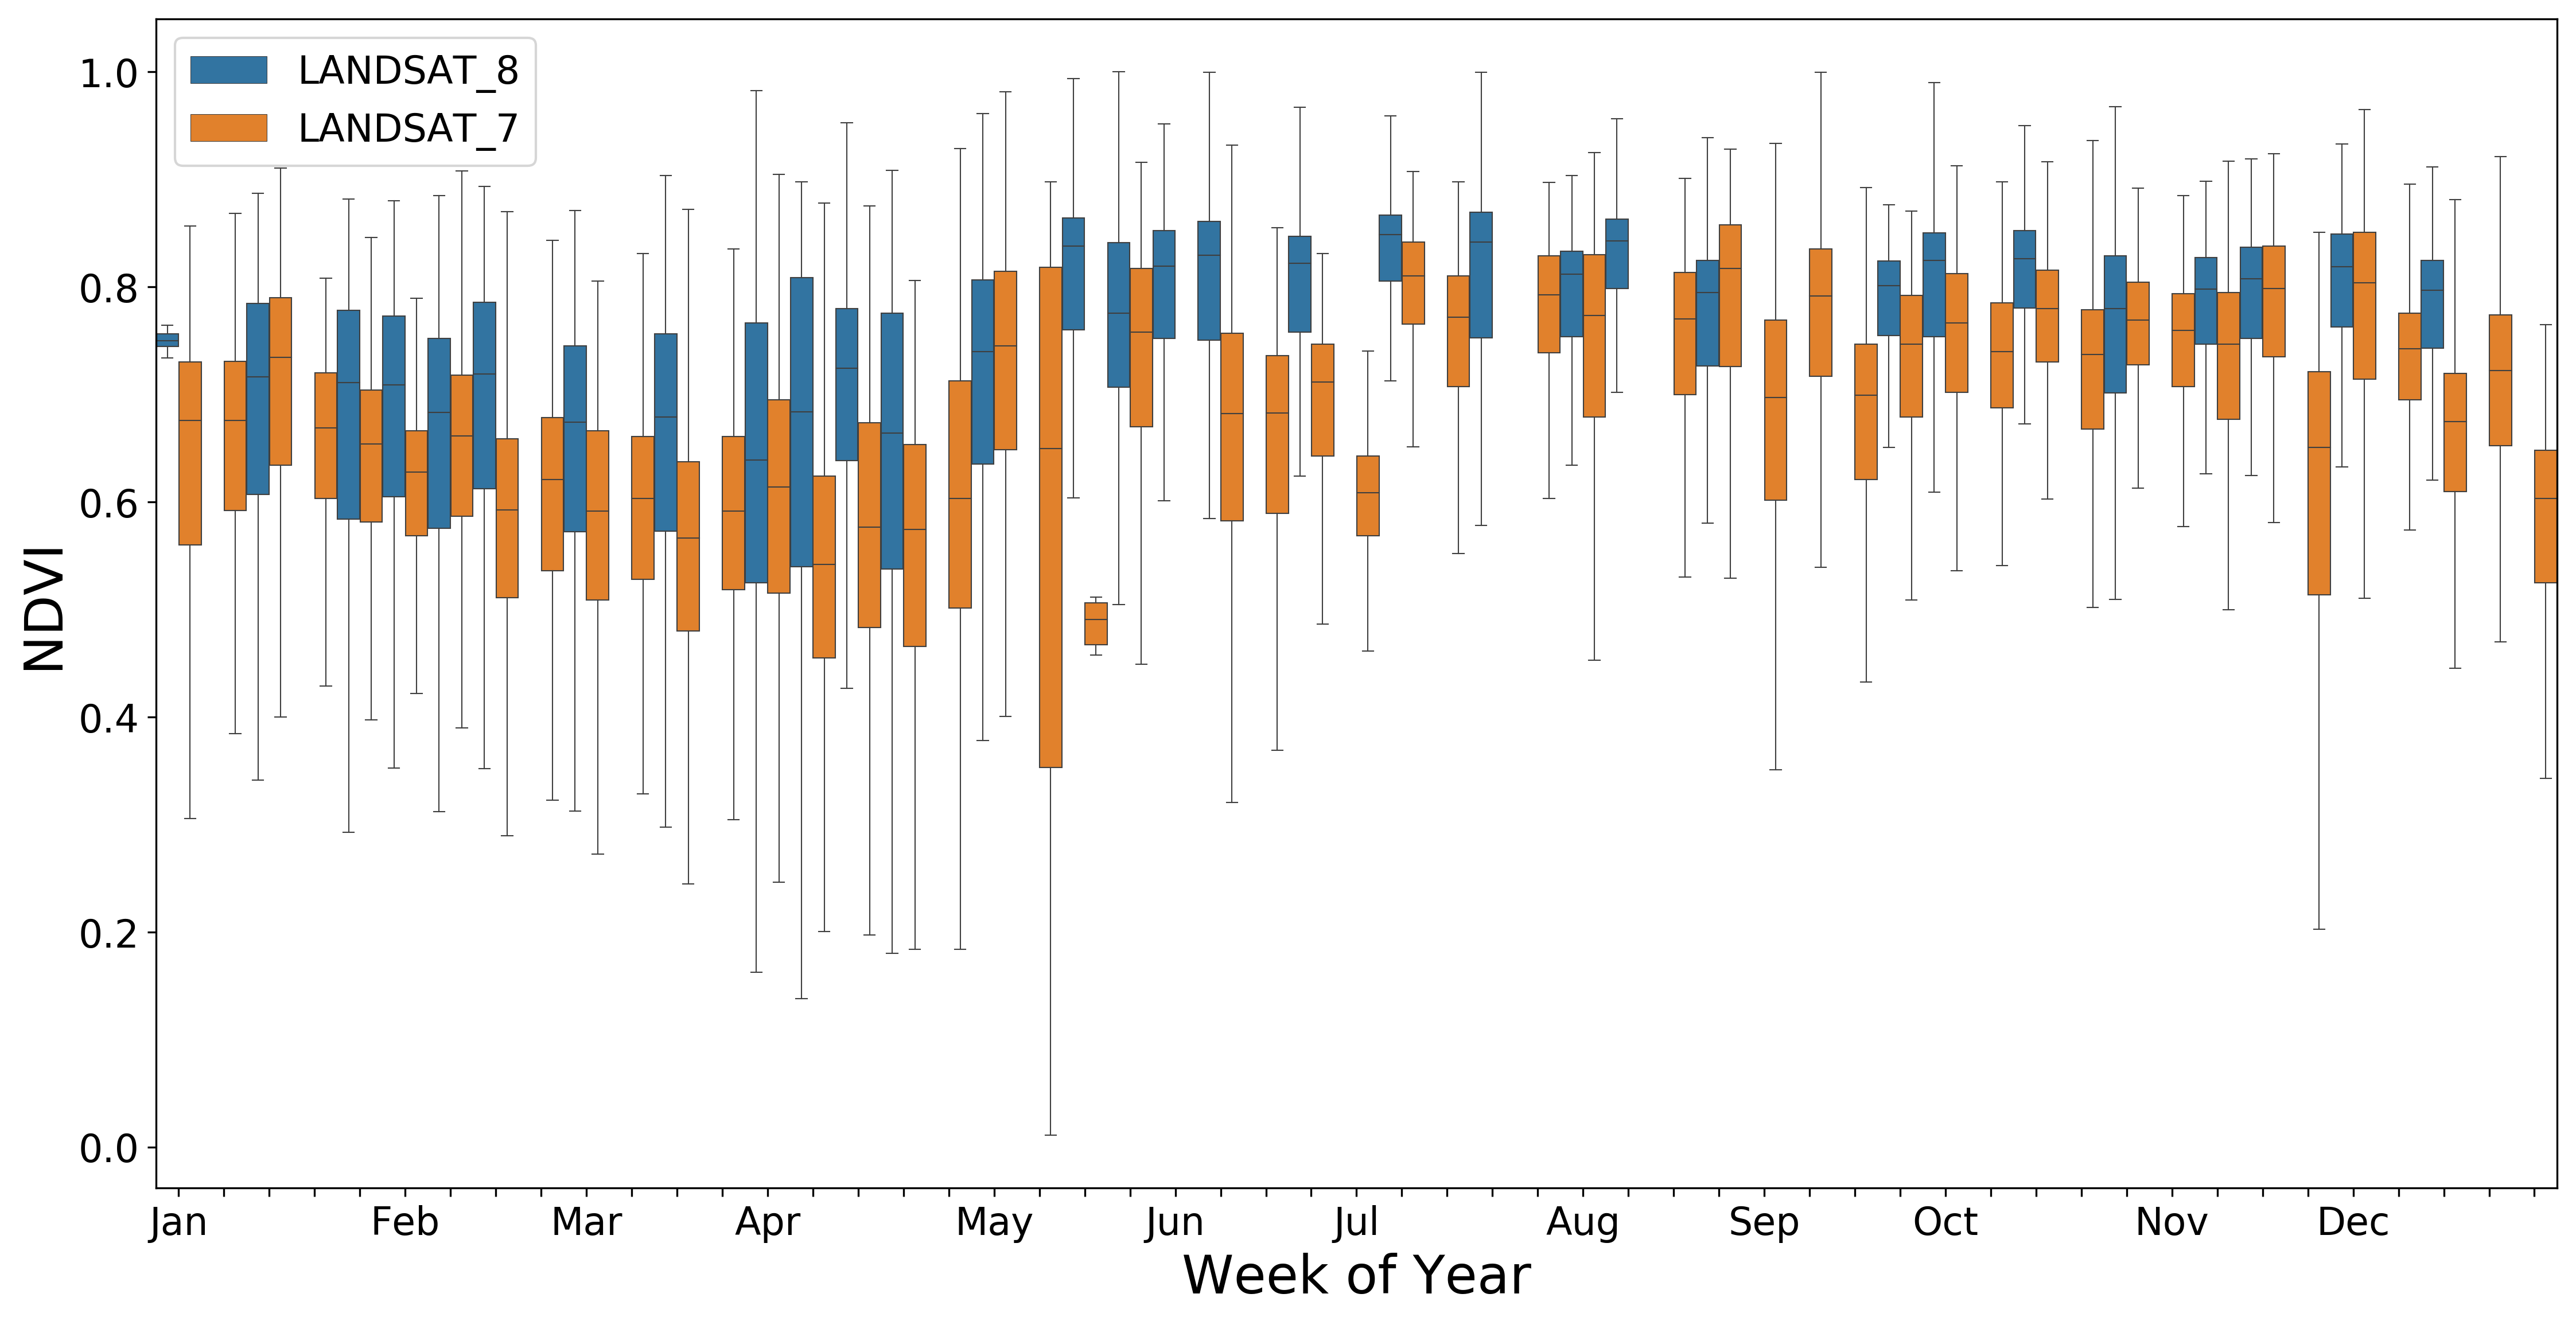

In [17]:
plot_area_boxplot_analysis('weekly', showfliers=False)

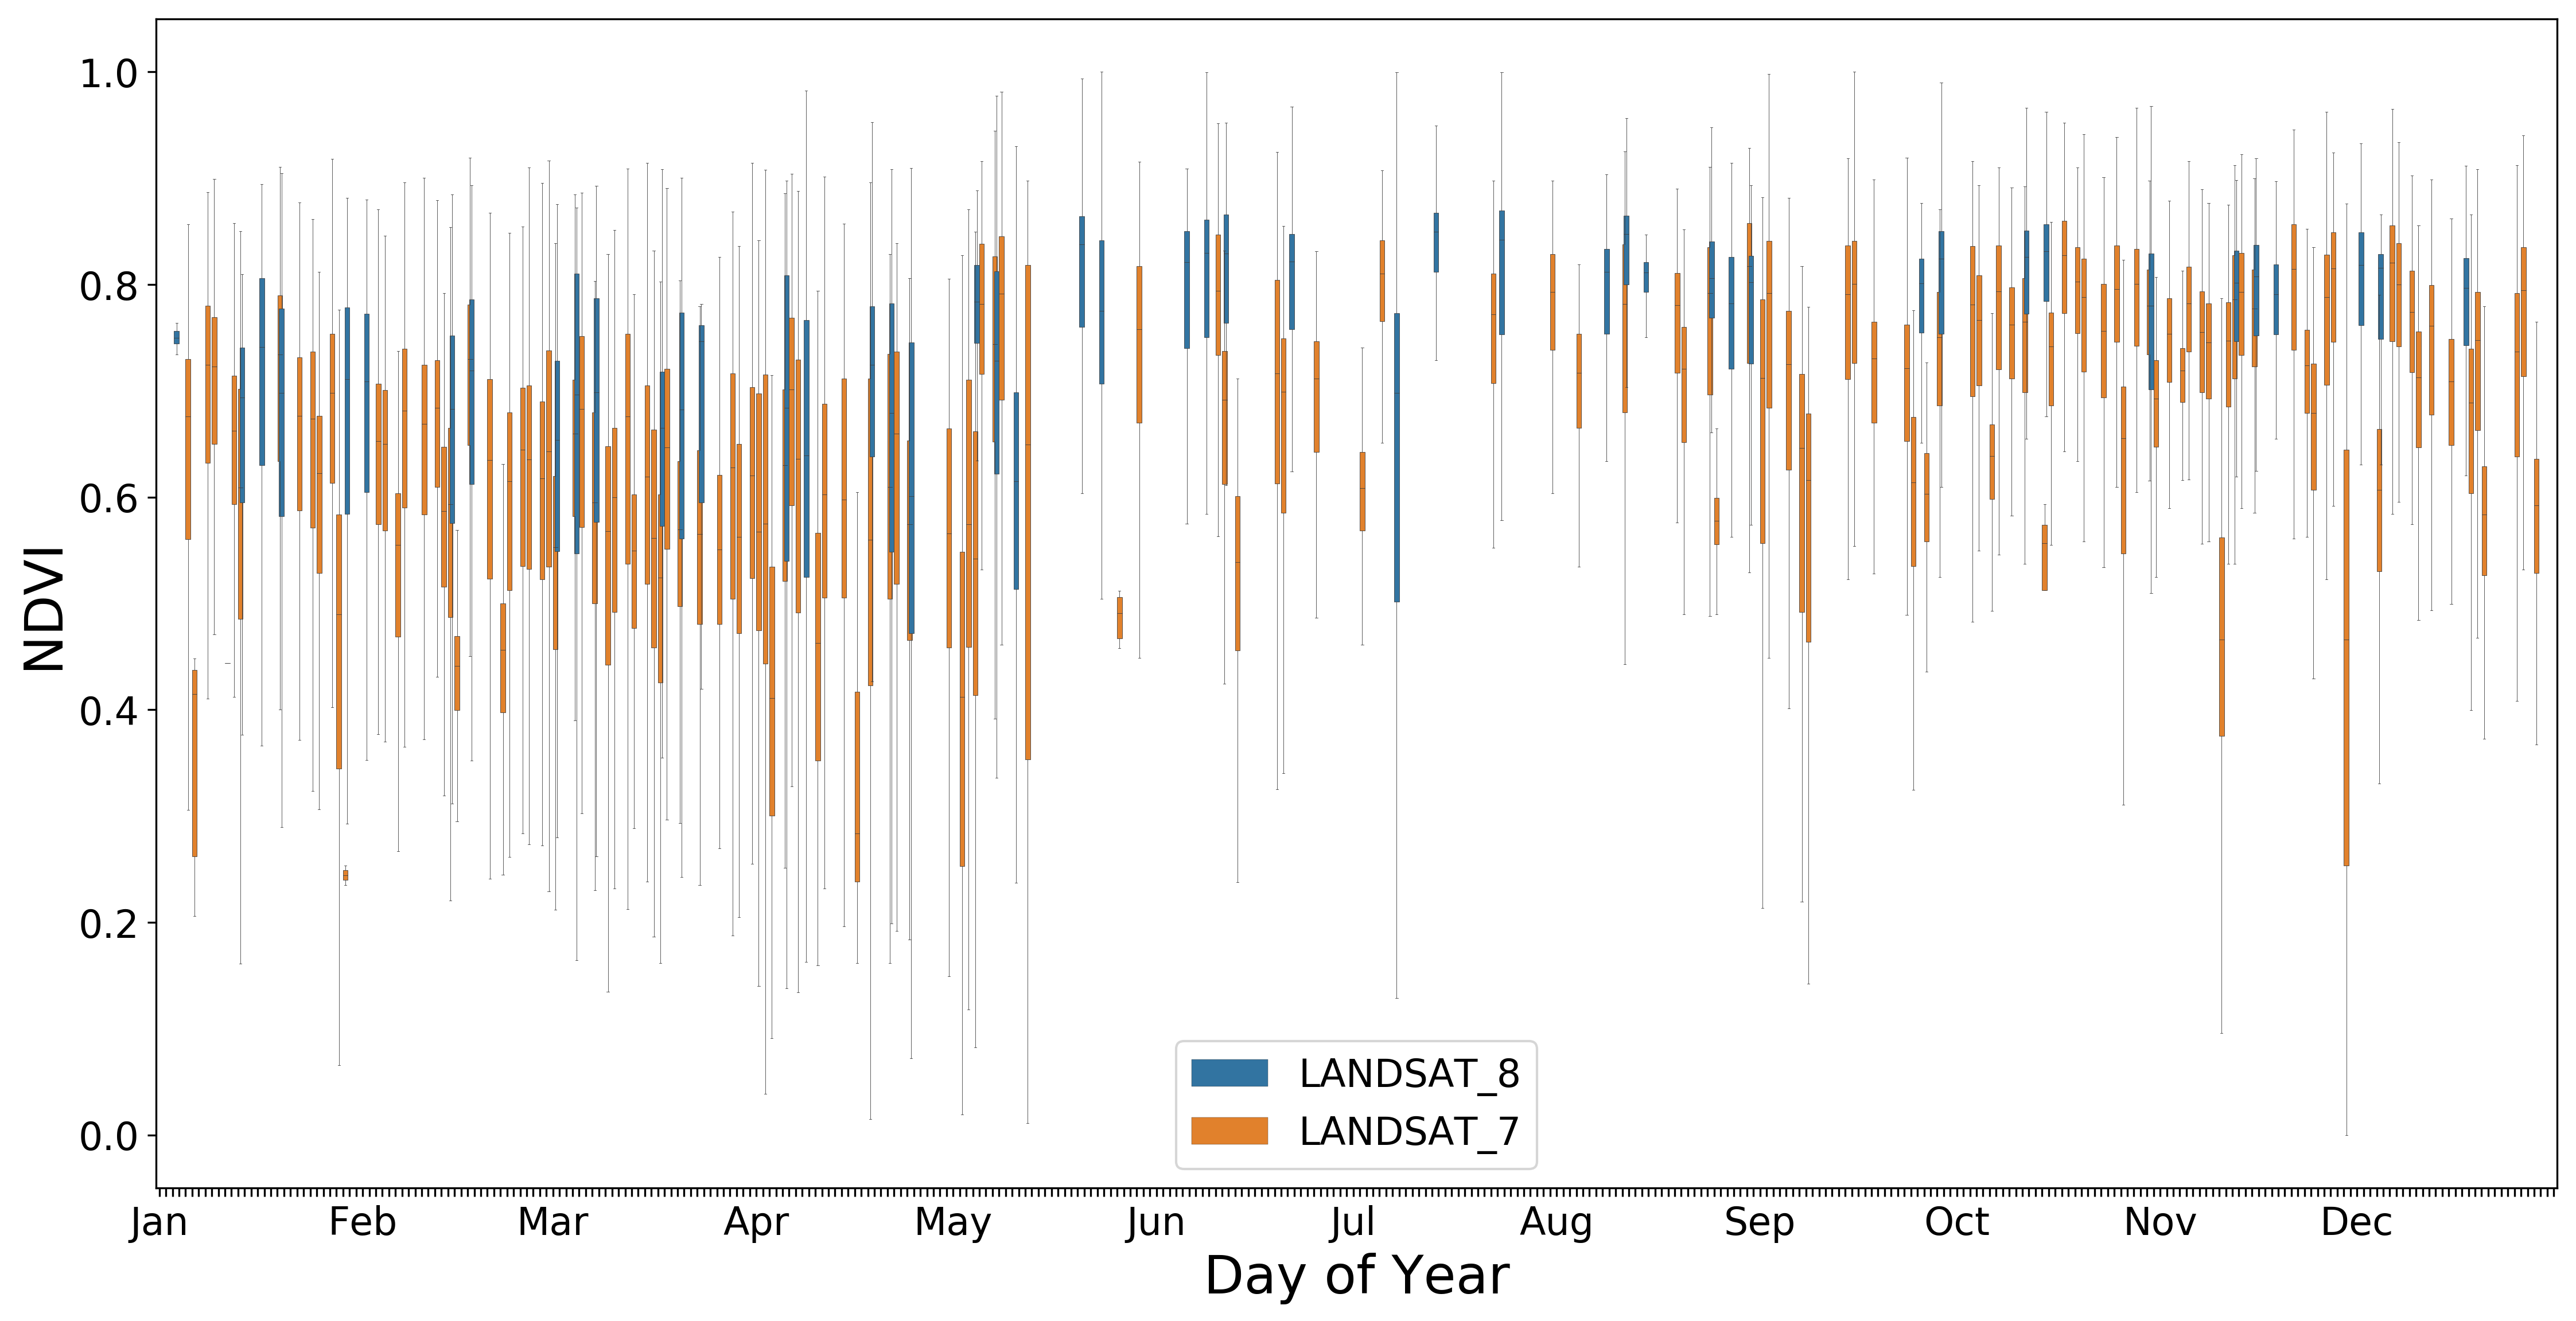

In [18]:
plot_area_boxplot_analysis('daily')

## <a id="point_analysis">Examine the selected point</a>

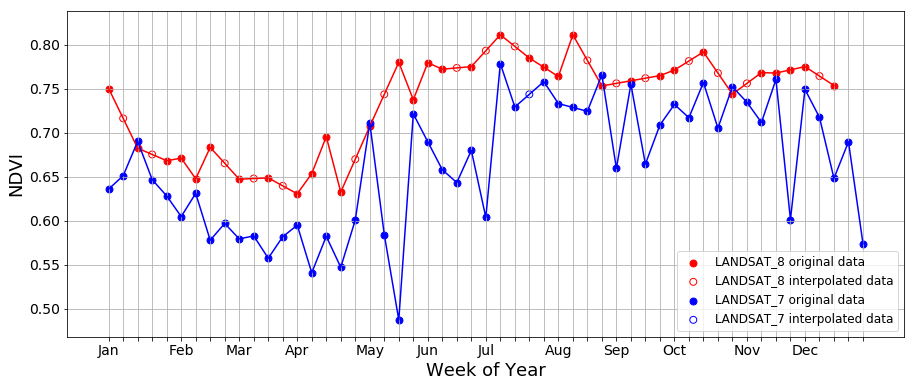

In [19]:
import utils.data_cube_utilities.plotter_utils as plotter
import importlib
importlib.reload(plotter)

# Simple time series plot for a single pixel analysis.
plt.figure(figsize=(15,6))
for i, platform in enumerate(comp_vals_arrs_dict.keys()):
    data_arr = comp_vals_arrs_dict[platform].comp_vals
    
    # Mean of computed values across time.
    data = data_arr.groupby('time.weekofyear').mean()
    
    # Add NaNs for weeks with no acquisitions.
    acquisition_week_nums = data.weekofyear.values
    num_weeks_per_year = 53
    resized_data = np.empty(num_weeks_per_year, dtype=np.float16)
    possible_week_nums = np.arange(1,num_weeks_per_year+1)
    missing_week_nums = np.setdiff1d(possible_week_nums, acquisition_week_nums)
    resized_data[acquisition_week_nums-1] = data.values
    resized_data[missing_week_nums-1] = np.nan
    # Create new DataArray for resized data.
    resized_data = xr.DataArray(resized_data, coords=[possible_week_nums], dims=['weekofyear'])
    
    # Linearly interpolate over missing values.
    resized_data = plotter.impute_missing_data_1D(resized_data)
    
    # Plot the original points, interpolating points, and connecting line.
    colors = ['red', 'blue']
    markersize = 48
    # solid circles for non-imputed values
    plt.scatter(possible_week_nums[acquisition_week_nums-1], 
                resized_data[acquisition_week_nums-1],
                label=platform + " original data", 
                marker='o', color=colors[i], s=markersize)
    # hollow circles for imputed values
    plt.scatter(possible_week_nums[missing_week_nums-1], 
                resized_data[missing_week_nums-1],
                label=platform + " interpolated data", 
                facecolors='none', edgecolor=colors[i], 
                s=markersize)
    plt.plot(possible_week_nums, resized_data, color=colors[i])
tick_label_fontsize = 14
plt.xticks(possible_week_nums, naive_months_ticks_by_week(), 
           fontsize=tick_label_fontsize)
plt.yticks(fontsize=tick_label_fontsize)
axis_label_fontsize = 18
plt.xlabel('Week of Year', fontsize=axis_label_fontsize)
plt.ylabel('NDVI', fontsize=axis_label_fontsize)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()